In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import datetime as dt
import math

#This library also requires installing fuzzywuzzy[speedup]
from fuzzywuzzy import process 

c:\python38\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Before running this, do a git pull on `../../college-covid19-dataset` (the big10 repo)

In [2]:
# nyt_datapath = '../UniversityCases/'
# big10_datapath = '../../college-covid19-dataset/data'
# In platform independent way
cwd = os.getcwd()
par = os.path.join(cwd, os.pardir)
par = os.path.abspath(par)
parpar = os.path.join(par, os.pardir)
parpar = os.path.abspath(parpar)
nyt_datapath = os.path.join(par, 'UniversityCases', '')
big10_datapath = os.path.join(parpar, 'college-covid19-dataset', 'data', '')

### Import and Clean Data

New York Times - All Schools

In [3]:
# I also had to change this part for myself (I couldn't get the re.search() to work)
# Feel free to change it back if it doesn't work for you now, the parts I changed are just commented

fnames = sorted(glob.glob(nyt_datapath+'*.csv'))
frames = []
for f in fnames:
    #m = re.search(r'[^0-9]*([0-9][0-9_]+)[^0-9]*', f)
    df = pd.read_csv(f)
    
    #df['Date'] = pd.to_datetime(m.group(1), format='%m_%d_%y')
    df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
    
    df.drop(['Unnamed: 0'], axis = 1, inplace=True)
    df['Cases'] = df['Cases'].apply(lambda x: x.replace(',', '')).astype('int')
    frames.append(df)
    
nyt_df = pd.concat(frames)

Big 10 - All dates

Data source: https://91-divoc.com/pages/covid-19-at-big-ten-conference-schools/

Note that this reports ALL cases among students, faculty, and staff (added together)

In [4]:
big10_df = pd.read_csv(os.path.join(big10_datapath, 'daily.csv'))
old_cols = big10_df.columns.values.copy()
old_cols[0] = 'School'
big10_df.columns = old_cols
big10_df['Date'] = pd.to_datetime(big10_df['Date'],format='%Y-%m-%d')

The next process drops all repeated data -- only keeps values that are different from the day before

In [5]:
# Found a faster way to do it by dropping duplicates
# It should work because cumulative cases are only ever increasing 

# NOTE: for both I'm only dropping based on case numbers 
#       (not tests or anything else)

nyt_df = nyt_df.drop_duplicates(subset = ['School','Cases'])
big10_df = big10_df.drop_duplicates(subset = ['School', 'Confirmed'])

# To do that I undid the Multi Indexes you had before so put them back:

nyt_df.index = pd.MultiIndex.from_frame(nyt_df[['School', 'Date']])
nyt_df.drop(['School', 'Date'], axis = 1, inplace = True)

big10_df.index = pd.MultiIndex.from_frame(big10_df[['School', 'Date']])
big10_df.drop(['School', 'Date'], axis = 1, inplace = True)

In [12]:
print(nyt_df.loc['Boston University'])

            Cases  County_Active_Cases  County_Total_Cases    City   County  \
Date                                                                          
2020-09-08     44              21677.0             22788.0  Boston  Suffolk   
2020-09-11     83              21914.0             23028.0  Boston  Suffolk   
2020-09-26    108              23043.0             24177.0  Boston  Suffolk   
2020-10-09    141              24238.0             25382.0  Boston  Suffolk   
2020-10-24    183              26178.0             27346.0  Boston  Suffolk   
2020-11-06    252              28871.0             30062.0  Boston  Suffolk   
2020-11-20    362              33046.0             34270.0  Boston  Suffolk   
2020-12-12    600              42690.0             43986.0  Boston  Suffolk   

                    State  
Date                       
2020-09-08  Massachusetts  
2020-09-11  Massachusetts  
2020-09-26  Massachusetts  
2020-10-09  Massachusetts  
2020-10-24  Massachusetts  
2020-11-06  M

Compute error as a function of time (shift until minimum error is found):

In [7]:
def shifter(b10_name, nyt_name):
    big_school = big10_df.loc[b10_name]
    nyt_school = nyt_df.loc[nyt_name]
    nyt_orig_dates = list(nyt_school.index)
    big10_dates = list(big_school.index)
    min_error = math.inf
    best_shift = 0
    
    # shift a max of 30 days 
    for i in range(30):
        nyt_dates = [d - dt.timedelta(days = i) for d in nyt_orig_dates]
        
        # Now the problem is finding the closest Big10 date for each of the nyt dates
        date_dict = {}
        count_up = 0
        big_up = 0
        closest = dt.timedelta(days = 365)
        
        while count_up < len(nyt_dates) and big_up < len(big10_dates):
            new_close = abs(big10_dates[big_up] - nyt_dates[count_up])

            if new_close < closest:
                closest = new_close
                big_up += 1
                
                if(big_up == len(big10_dates)):
                    date_dict[nyt_dates[count_up]] = big10_dates[big_up - 1]
                    closest = dt.timedelta(days = 365)
                    count_up += 1
            else:
                date_dict[nyt_dates[count_up]] = big10_dates[big_up - 1]
                closest = dt.timedelta(days = 365)
                count_up += 1
                
        # Now just compute average error for the shifted dates
        avg_error = 0
        for j in date_dict.keys():
            nyt_case = nyt_school.loc[j + dt.timedelta(days = i), 'Cases']
            big_case = big_school.loc[date_dict[j], 'Confirmed']
            err = abs(nyt_case - big_case)
            avg_error += err
            
        avg_error /= len(date_dict.keys())
        
        # if its better than what we have so far, record it
        if avg_error < min_error:
            min_error = avg_error
            best_shift = i
        
    return best_shift
        
    

In [8]:
# plot with a shift
def plot_shift(b10_name, nyt_name, shift):
    fig, ax = plt.subplots(1)
    big10_df.loc[b10_name]['Confirmed'].plot(style = '.-', ax = ax, label = 'Big10')
    nyt_df.loc[nyt_name]['Cases'].plot(style = '.-', ax = ax, label = 'NYT')
    nyt_school = nyt_df.loc[nyt_name]
    nyt_new_dates = [i - dt.timedelta(shift) for i in list(nyt_school.index)]
    nyt_school.index = nyt_new_dates
    nyt_school.loc[:,'Cases'].plot(style = '.-', ax = ax, label = 'NYT shift')
    
    plt.suptitle('NYT: {}'.format(nyt_name) + " shifted " + str(shift) + " days")
    plt.title('Big 10: {}'.format(b10_name))
    plt.legend(loc = 'best')

Now use the functions above on all big 10 schools:

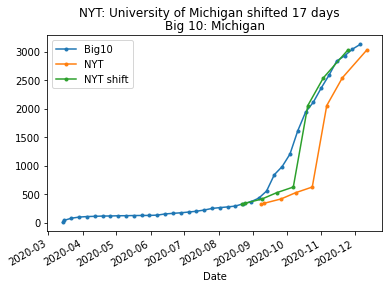

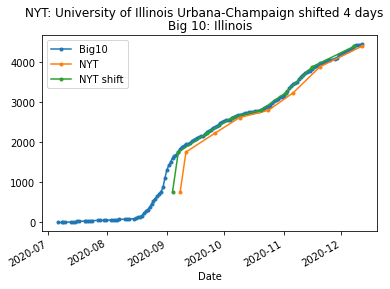

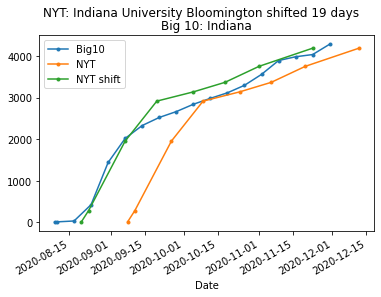

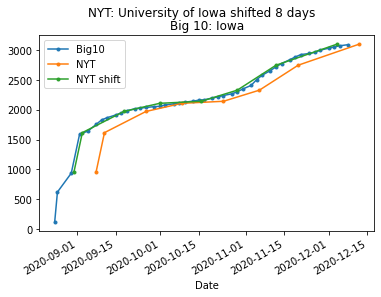

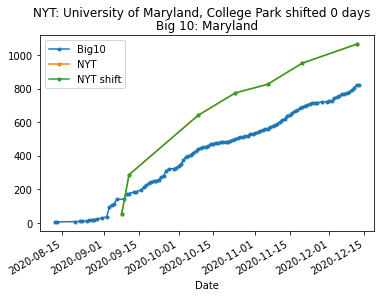

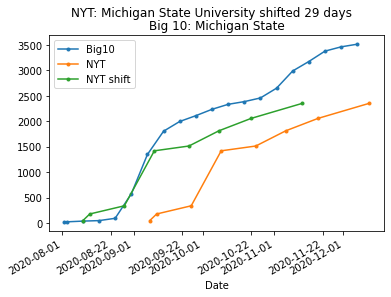

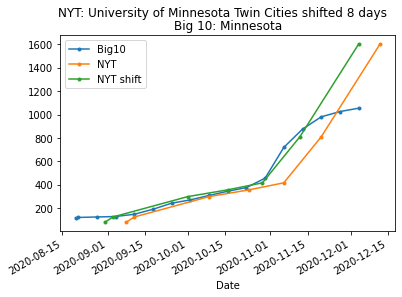

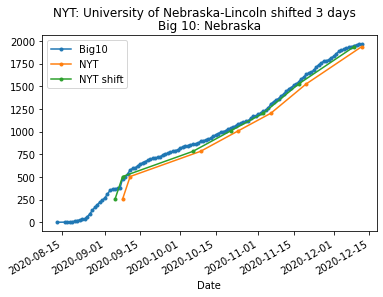

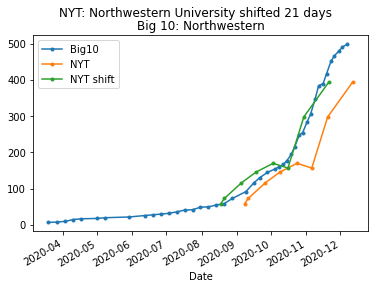

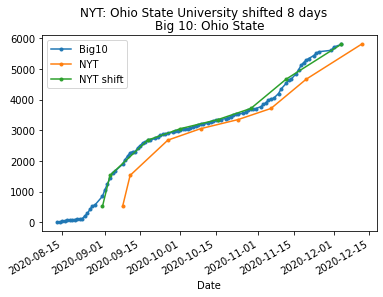

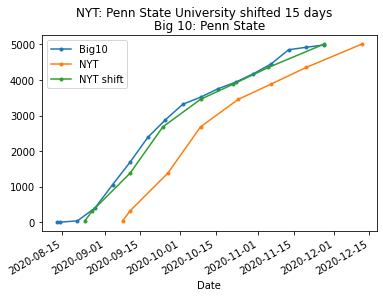

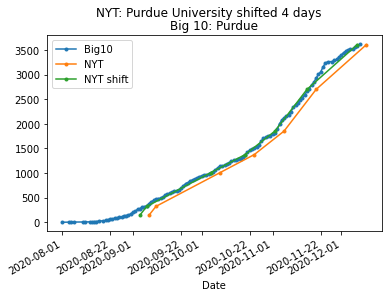

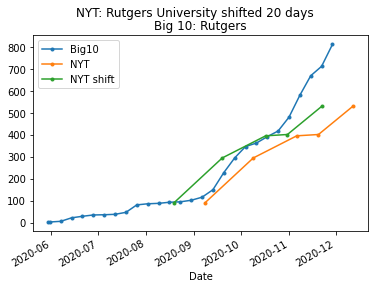

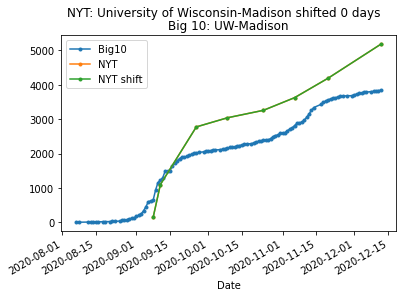

In [9]:
name_translator = [('Michigan', 'University of Michigan'), 
                           ('Illinois', 'University of Illinois Urbana-Champaign'),
                           ('Indiana', 'Indiana University Bloomington'),
                           ('Iowa', 'University of Iowa'),
                           ('Maryland', 'University of Maryland, College Park'),
                           ('Michigan State', 'Michigan State University'),
                           ('Minnesota', 'University of Minnesota Twin Cities'),
                           ('Nebraska', 'University of Nebraska-Lincoln'),
                           ('Northwestern', 'Northwestern University'),
                           ('Ohio State', 'Ohio State University'),
                           ('Penn State', 'Penn State University'),
                           ('Purdue', 'Purdue University'),
                           ('Rutgers', 'Rutgers University'),
                           ('UW-Madison', 'University of Wisconsin-Madison')]

for b10_name, nyt_name in name_translator:
    shift = shifter(b10_name, nyt_name)
    plot_shift(b10_name, nyt_name, shift)
    